# Dueling double Deep Q-Network  
  
This implementation I took from [marload repository](https://github.com/marload/DeepRL-TensorFlow2/blob/master/DuelingDoubleDQN/DuelingDoubleDQN_Discrete.py) and fit to ConnectX game.

In [1]:
!pip install kaggle-environments

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


A little change ConnectX environment

In [2]:
from kaggle_environments import evaluate, make, utils
from gym import spaces
class ConnectX:
    DRAW = 0.5
    WIN = 1
    LOSE = -1
    ERROR = -10 
    
    def __init__(self, pair=[None, "random"], config = {"rows": 6, "columns": 7, "inarow": 4}):
        self.ks_env = make("connectx", config, debug=True)
        self.pair = pair
        self.env = self.ks_env.train(pair)
        self.config = config
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(config["columns"])
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(config["rows"],config["columns"],1), dtype=np.int)

        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
        
    def reset(self):
        self.obs = self.env.reset()
        self.obs = self.get_board(self.obs, self.config)
        return self.obs
    
    def switch_pair(self):
        self.pair = self.pair[::-1]
        self.env = self.ks_env.train(self.pair)
        
    def change_pair(self, pair):
        self.pair = pair
        self.env = self.ks_env.train(self.pair)
        
    def change_reward(self, reward, done):
        
        if done:
            if reward is None: #Error 
                reward = ConnectX.ERROR
            elif reward == 1:
                reward = ConnectX.WIN
            elif reward == -1:
                reward = ConnectX.LOSE
            elif reward == 0:
                reward = ConnectX.DRAW
        else:
            reward = -1/(self.config['rows'] * self.config['columns'])
            
        return reward
    
    # get board independent of player number
    def get_board(self, observation, configuration):
        rows = configuration['rows']
        columns = configuration['columns']

        board = np.array(observation['board']).reshape((rows,columns,1))
        new_board = np.zeros_like(board)

        mark = observation["mark"]
        new_board[board == mark] = 1
        new_board[(board != mark) & (board != 0)] = 2
        return new_board / 2 #normalization
    
    def step(self, action):
        if not np.any(self.obs[:, action] == 0):
            reward, done, _ = ConnectX.ERROR, True, {}
        else:
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
            self.obs = self.get_board(self.obs, self.config)
        
        return self.obs, reward, done, _

Loading environment football failed: No module named 'gfootball'


In [3]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
from collections import deque
import random

tf.keras.backend.set_floatx('float64')

BATCH_SIZE = 64
DISCOUNT = 0.99

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def put(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, reward, next_state, done])
    
    def sample(self):
        sample = random.sample(self.buffer, BATCH_SIZE)
        states, actions, rewards, next_states, done = map(np.asarray, zip(*sample))
        return states, actions, rewards, next_states, done
    
    def size(self):
        return len(self.buffer)

class ActionStateModel:
    
    def __init__(self, state_dim, aciton_dim, epsilon = 1.0, eps_decay = 0.999, eps_min = 0.01, lr = 0.007):
        self.state_dim  = state_dim
        self.action_dim = aciton_dim
        
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.lr = lr

        self.model = self.create_model()
        
    # you can create your model, and experiment with it
    def create_model(self):
        state_input = Input(self.state_dim)
        initializer = tf.initializers.VarianceScaling(scale=2.0)
#         layers = [    
#             Conv2D(64, 3, activation='relu', kernel_initializer=initializer, kernel_regularizer='l2'),
#             BatchNormalization(),
#             Conv2D(64, 2, activation='relu', kernel_regularizer='l2', kernel_initializer=initializer),
#             BatchNormalization(),
#             Flatten(),
#             Dense(50, activation='relu', kernel_regularizer='l2', kernel_initializer=initializer),
#             BatchNormalization(),
#             Dropout(0.1),
#             Dense(20, activation='relu', kernel_regularizer='l2', kernel_initializer=initializer),
#         ]
        
        layers = [ 
            Conv2D(20, (5, 5), padding='same'),
            LeakyReLU(alpha=0.3),
            Conv2D(20, (4, 4), padding='same'),
            LeakyReLU(alpha=0.3),
            Conv2D(20, (4, 4), padding='same'),
            LeakyReLU(alpha=0.3),
            Conv2D(30, (4, 4), padding='same'),
            LeakyReLU(alpha=0.3),
            Conv2D(30, (4, 4), padding='same'),
            LeakyReLU(alpha=0.3),
            Conv2D(30, (4, 4), padding='same'),
            LeakyReLU(alpha=0.3),
            Flatten(),
            Dense(50, activation='relu', kernel_regularizer='l2', kernel_initializer=initializer),
            BatchNormalization(),
            Dropout(0.1),
            Dense(20, activation='relu', kernel_regularizer='l2', kernel_initializer=initializer),
        ]        
        
        backbone = tf.keras.Sequential(layers)(state_input)
        value_output = Dense(1)(backbone)
        advantage_output = Dense(self.action_dim)(backbone)
        output = Add()([value_output, advantage_output])
        model = tf.keras.Model(state_input, output)
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))    
        return model
    
    def predict(self, state):
        return self.model.predict(state)
    
    def get_action(self, state):
        state = np.reshape(state, [1, *self.state_dim])
        self.epsilon *= self.eps_decay
        self.epsilon = max(self.epsilon, self.eps_min)
        q_value = self.predict(state)[0]
        if np.random.random() < self.epsilon:
            return random.randint(0, self.action_dim-1)
        return np.argmax(q_value)

    def train(self, states, targets):
        self.model.fit(states, targets, epochs=1, verbose=0)

        
class Agent:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape
        self.action_dim = self.env.action_space.n

        self.model = ActionStateModel(self.state_dim, self.action_dim)
        self.target_model = ActionStateModel(self.state_dim, self.action_dim)
        self.target_update()

        self.buffer = ReplayBuffer()

    def target_update(self):
        weights = self.model.model.get_weights()
        self.target_model.model.set_weights(weights)
    
    def replay(self):
        for _ in range(10):
            states, actions, rewards, next_states, done = self.buffer.sample()
            targets = self.target_model.predict(states)
            next_q_values = self.target_model.predict(next_states)[range(BATCH_SIZE),np.argmax(self.model.predict(next_states), axis=1)]
            targets[range(BATCH_SIZE), actions] = rewards + (1-done) * next_q_values * DISCOUNT 
            self.model.train(states, targets)

    def _print_statistics(self, rewards):
        rewards = np.array(rewards)
        print("Wins:", (rewards == ConnectX.WIN).sum())
        print("Loses:", (rewards == ConnectX.LOSE).sum())
        print("Errors:", (rewards == ConnectX.ERROR).sum())
        
    def train(self, episodes=1000, every = 100, switch = False):
        rewards = []
        total_rewards = []
        for ep in range(episodes):
            done, total_reward = False, 0
            state = self.env.reset()
            while not done:
                action = self.model.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                
                self.buffer.put(state, action, reward, next_state, done)
                #put symmetrical state
                self.buffer.put(state[:, ::-1, :], agent.action_dim - 1 - action, reward, next_state[:, ::-1, :], done)
                total_reward += reward
                state = next_state
            
            if self.buffer.size() >= BATCH_SIZE:
                self.replay()
            self.target_update()
            
            if (ep + 1) % 10 == 0:
                print('EP {} EpisodeReward={}'.format(ep + 1, total_reward))
            total_rewards.append(total_reward)
            rewards.append(reward)
            
            if (ep + 1) % every == 0:
                if switch:
                    self.env.switch_pair()
                self._print_statistics(rewards)
                rewards = []
        
        return total_rewards

def plot(x, h = 100):
    plt.plot(np.convolve(x, np.ones(h), 'valid')/h)
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.show()

In [4]:
# Here I experiment with only Connect 3.
env = ConnectX(pair = ["random", None ], config = {"rows": 4, "columns": 5, "inarow": 3})
agent = Agent(env)

EP 10 EpisodeReward=0.85
EP 20 EpisodeReward=0.85
EP 30 EpisodeReward=-1.1
EP 40 EpisodeReward=-1.15
EP 50 EpisodeReward=-1.1
EP 60 EpisodeReward=-1.2
EP 70 EpisodeReward=0.85
EP 80 EpisodeReward=0.85
EP 90 EpisodeReward=-1.1
EP 100 EpisodeReward=0.85
Wins: 38
Loses: 50
Errors: 12
EP 110 EpisodeReward=0.75
EP 120 EpisodeReward=0.75
EP 130 EpisodeReward=0.9
EP 140 EpisodeReward=-10.2
EP 150 EpisodeReward=-10.2
EP 160 EpisodeReward=-1.2
EP 170 EpisodeReward=0.85
EP 180 EpisodeReward=0.8
EP 190 EpisodeReward=-1.1
EP 200 EpisodeReward=-10.15
Wins: 58
Loses: 23
Errors: 19
EP 210 EpisodeReward=0.9
EP 220 EpisodeReward=0.9
EP 230 EpisodeReward=-10.15
EP 240 EpisodeReward=-1.1
EP 250 EpisodeReward=-10.2
EP 260 EpisodeReward=0.9
EP 270 EpisodeReward=-10.2
EP 280 EpisodeReward=0.9
EP 290 EpisodeReward=-1.05
EP 300 EpisodeReward=-1.1
Wins: 46
Loses: 32
Errors: 22
EP 310 EpisodeReward=0.85
EP 320 EpisodeReward=-1.15
EP 330 EpisodeReward=0.9
EP 340 EpisodeReward=0.9
EP 350 EpisodeReward=-1.2
EP 360

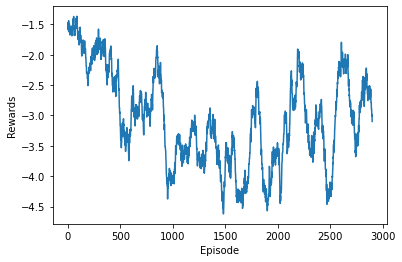

In [5]:
total_rewards = agent.train(episodes = 3000, every = 100, switch = True)
plot(total_rewards, 100)

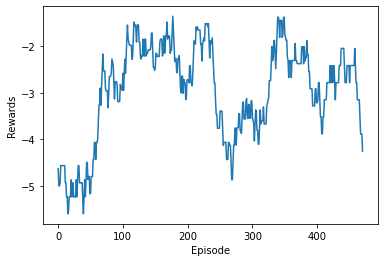

In [6]:
# Plot last 500 games
plot(total_rewards[-500:], 30)

EP 10 EpisodeReward=-1.1
EP 20 EpisodeReward=-1.1
EP 30 EpisodeReward=-1.2
EP 40 EpisodeReward=-1.1
EP 50 EpisodeReward=-1.1
EP 60 EpisodeReward=-1.1
EP 70 EpisodeReward=-1.15
EP 80 EpisodeReward=-1.1
EP 90 EpisodeReward=-1.1
EP 100 EpisodeReward=-1.15
Wins: 1
Loses: 87
Errors: 12
EP 110 EpisodeReward=-10.1
EP 120 EpisodeReward=-1.05
EP 130 EpisodeReward=-1.05
EP 140 EpisodeReward=-1.1
EP 150 EpisodeReward=-1.05
EP 160 EpisodeReward=-1.15
EP 170 EpisodeReward=-1.05
EP 180 EpisodeReward=-1.05
EP 190 EpisodeReward=-1.05
EP 200 EpisodeReward=-1.05
Wins: 0
Loses: 97
Errors: 3
EP 210 EpisodeReward=-1.2
EP 220 EpisodeReward=-10.15
EP 230 EpisodeReward=0.75
EP 240 EpisodeReward=-1.2
EP 250 EpisodeReward=-1.15
EP 260 EpisodeReward=-1.2
EP 270 EpisodeReward=-1.2
EP 280 EpisodeReward=-1.15
EP 290 EpisodeReward=-1.1
EP 300 EpisodeReward=-1.15
Wins: 1
Loses: 72
Errors: 27
EP 310 EpisodeReward=-1.1
EP 320 EpisodeReward=-1.05
EP 330 EpisodeReward=-1.05
EP 340 EpisodeReward=-1.05
EP 350 EpisodeReward

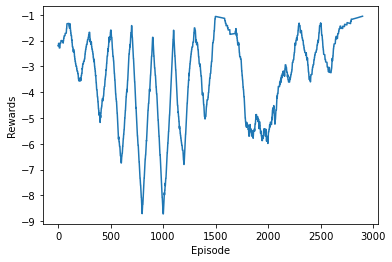

In [7]:
agent.model.epsilon = 1.0
env.change_pair([None, "negamax"])
total_rewards = agent.train(episodes= 3000, every = 100, switch = True)
plot(total_rewards, 100)

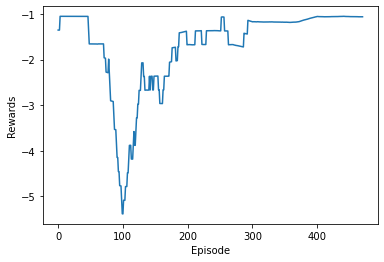

In [8]:
# Plot last 500 games
plot(total_rewards[-500:], 30)

# Conclusion  
As you can see, dueling double DQN doesn't solve Connect 3 game. And I don't have idea why. I also tried usual DQN and PPO algorithm with different model architectures, but get the same result.  

Leave comment and write, where I can have a mistake. 

My other notebooks:  
1) [Usual DQN](https://www.kaggle.com/masurte/deep-q-learning)   
2) [Usual DQN, my own implementation](https://www.kaggle.com/masurte/deep-q-learning-implementation)  
3) [PPO](https://www.kaggle.com/masurte/ppo-algorithm)  
